### Debug

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt

In [167]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [770]:
import numpy as np
import random
from dynaconf import settings
from data import EEGDataset, normalize

In [285]:
torch.manual_seed(1)

##### Synthetic Data

In [169]:
def get_sin_wave(length, freq):
    t = np.arange(length)
    x = np.sin(2*np.pi * (1/freq) * t)
    return x

In [737]:
X_train = []
y_train = []
for i in range(300):
    example = (get_sin_wave(length=260, freq=random.randint(32, 64)).reshape(1, -1) + 2)/2
    start = 0
    end = start + 250
    pred_end = end + 10
    X_train.append(example[:, start:end])
    y_train.append(example[:, end:pred_end])

In [171]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

##### Real Data

In [733]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
real_train_dataset = EEGDataset(train_dataset_csv, 5000, [1], max_num_examples=-1, transform=normalize)

X_real_train = []
y_real_train = []
for i in range(len(real_train_dataset)):
    for j in range(3):
        example = real_train_dataset[i].numpy()
        start = random.randint(0, 4700)
        end = start + 250
        pred_end = end + 10
        X_real_train.append(example[:, start:end])
        y_real_train.append(example[:, end:pred_end])

Found 2765 recordings
By set limit only using 2764 recordings
Removing recordings of insufficient length...
Removed 93 of 2764 recordings. There are now 2671 recordings.


In [734]:
dev_dataset_csv = settings.DEV_DATASET_CSV
real_eval_dataset = EEGDataset(dev_dataset_csv, 5000, [1], max_num_examples=-1, transform=normalize)

X_real_eval = []
y_real_eval = []
for i in range(len(real_eval_dataset)):
    for j in range(3):
        example = real_eval_dataset[i].numpy()
        start = random.randint(0, 4700)
        end = start + 250
        pred_end = end + 10
        X_real_eval.append(example[:, start:end])
        y_real_eval.append(example[:, end:pred_end])

Found 345 recordings
By set limit only using 344 recordings
Removing recordings of insufficient length...
Removed 13 of 344 recordings. There are now 331 recordings.


In [738]:
X_train = np.asarray(X_real_train)
y_train = np.asarray(y_real_train)
X_eval = np.asarray(X_real_eval)
y_eval = np.asarray(y_real_eval)

#### Pytorch Model

In [739]:
import torch
import torch.nn as nn
from torch.autograd import Variable

limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units).

In [740]:
class TorchLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=80, num_layers=2, output_size=1, n_predictions=10, dropout=.3):
        super().__init__()
        self.output_size = output_size
        self.n_predictions = n_predictions
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_layer_size, n_predictions * output_size)
        
        self.lstm.reset_parameters = self.reset_parameters
        self.lstm.reset_parameters()


    def forward(self, input_seq):
        out, (_, _) = self.lstm(input_seq)
        preds = self.fc1(out[:,-1].squeeze()).squeeze()
        return preds
    
    def reset_parameters(self):

        for name, param in self.named_parameters():
            if "weight_hh" in name:
                # recurrent weight 
                torch.nn.init.orthogonal_(param)
                
            elif "weight_ih" in name:
                # kernel weight 
                # glorot initialization
                torch.nn.init.xavier_uniform_(param)
            
            elif "bias" in name:
                torch.nn.init.zeros_(param)
                    
#     def reset_parameters(self) -> None:
#         for param in self.parameters():
#             shape = param.shape 
#             if len(shape) == 2:
#                 # it's a recurrent weight
#                 torch.nn.init.orthogonal(param)

#             elif len(shape) == 1:
#                 # it's a bias
#                 torch.nn.init.zeros_(param)
                
#             else:
#                 print("Suspect Weight shape found", shape)
                

In [741]:
model = TorchLSTM()

things to check
- initialization 
- check outputs vs keras

In [742]:
from torch.utils.data import TensorDataset, DataLoader

In [743]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

eval_dataset = TensorDataset(torch.Tensor(X_eval), torch.Tensor(y_eval))
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=True)

In [744]:
def train_model(num_epochs):
    torch_model.train()
    running_losses = []
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            a = torch_model(x.transpose(1,2))
            loss = criteron(a.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()
            
            running_losses.append(loss.item())
            if i % 50 == 0:
                eval_losses = eval_model()
                eval_losses_avg = sum(eval_losses) / len(eval_losses)
                running_losses_avg = sum(running_losses)/len(running_losses)
                cur_iter = len(train_loader) * epoch + i
                print(f"epoch {epoch} | iter {cur_iter} | Running Loss {running_losses_avg} | Eval Loss {eval_losses_avg}")
                running_losses.clear()
                
def eval_model():
    torch_model.eval()
    running_losses = []
    for i, (x, y) in enumerate(eval_loader):
        with torch.no_grad():
            x, y = x.cuda(), y.cuda()
            a = torch_model(x.transpose(1,2))
            loss = criteron(a.squeeze(), y.squeeze())
            running_losses.append(loss.item())
    torch_model.train()
    return running_losses

In [745]:
torch_model = TorchLSTM(n_predictions=10, hidden_layer_size=80, num_layers=2)
torch_model.cuda()
criteron = nn.MSELoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=.01)

In [746]:
train_model(25)

epoch 0 | iter 0 | Running Loss 0.2787024974822998 | Eval Loss 0.2036999799311161
epoch 0 | iter 50 | Running Loss 0.08171006552875042 | Eval Loss 0.018146234389860183
epoch 0 | iter 100 | Running Loss 0.009498484930954874 | Eval Loss 0.004566330317175016
epoch 1 | iter 126 | Running Loss 0.0053997364145918535 | Eval Loss 0.007010062632616609
epoch 1 | iter 176 | Running Loss 0.005883662407286465 | Eval Loss 0.004882116103544831
epoch 1 | iter 226 | Running Loss 0.005229338854551315 | Eval Loss 0.004603830340784043
epoch 2 | iter 252 | Running Loss 0.0052185538762177415 | Eval Loss 0.004141112789511681
epoch 2 | iter 302 | Running Loss 0.005469821561127901 | Eval Loss 0.004251598205883056
epoch 2 | iter 352 | Running Loss 0.004705750923603773 | Eval Loss 0.004646161061828025
epoch 3 | iter 378 | Running Loss 0.005716742034285114 | Eval Loss 0.004613152326783165
epoch 3 | iter 428 | Running Loss 0.005201498214155435 | Eval Loss 0.004105426574824378
epoch 3 | iter 478 | Running Loss 0.00

In [442]:
torch.save(torch_model.cpu().state_dict(), "./models/saved_models/lstmWIIv01.pt")

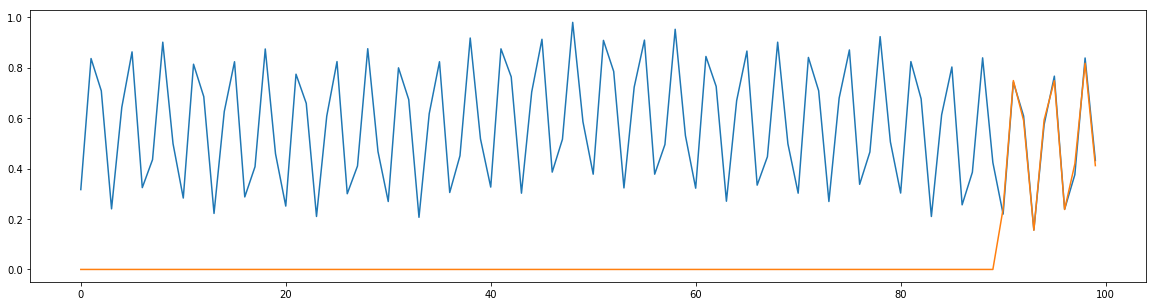

In [747]:
torch_model.eval()
i = random.randint(0, X_train.shape[0])
example = X_train[i]
example = torch.from_numpy(example.reshape(1, 250, 1)).type('torch.FloatTensor').cuda()
pred = torch_model(example).detach().cpu().numpy()
combined = np.concatenate([example[0].cpu().numpy(), y_train[i].T], axis=0).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example.cpu().squeeze()),pred.squeeze()]).squeeze()

plt.plot(combined[-100:])
plt.plot(combined_zeros[-100:])

#### Keras Model

In [750]:
import tensorflow

In [751]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping, Callback
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
import numpy as np
import os

In [752]:
# initializer = tf.keras.initializers.RandomUniform(minval=-k, maxval=k)
initializer = tf.keras.initializers.Orthogonal()

In [753]:
model = Sequential()

model.add(LSTM(
    80,
    input_shape=(None, X_train.shape[2]),
    return_sequences=True,)
#     kernel_initializer=initializer,
#     recurrent_initializer=initializer)
)

model.add(Dropout(.3))

model.add(LSTM(
    80,
    return_sequences=False,
    kernel_initializer=initializer,
    recurrent_initializer=initializer)
)

model.add(Dropout(.3))

model.add(Dense(10))
model.add(Activation('linear'))

model.compile(loss='mse',
               optimizer='adam')

model.fit(X_train,
    y_train.squeeze(),
    batch_size=64,
    epochs=25,
#     validation_split=.2,
)

Epoch 1/25
8013/8013 [==============================] - 2s 249us/step - loss: 0.0380
Epoch 2/25
8013/8013 [==============================] - 1s 92us/step - loss: 0.0129
Epoch 3/25
8013/8013 [==============================] - 1s 91us/step - loss: 0.0103
Epoch 4/25
8013/8013 [==============================] - 1s 91us/step - loss: 0.0086
Epoch 5/25
8013/8013 [==============================] - 1s 92us/step - loss: 0.0079
Epoch 6/25
8013/8013 [==============================] - 1s 92us/step - loss: 0.0073
Epoch 7/25
8013/8013 [==============================] - 1s 93us/step - loss: 0.0068
Epoch 8/25
8013/8013 [==============================] - 1s 92us/step - loss: 0.0064
Epoch 9/25
8013/8013 [==============================] - 1s 90us/step - loss: 0.0067
Epoch 10/25
8013/8013 [==============================] - 1s 87us/step - loss: 0.0061
Epoch 11/25
8013/8013 [==============================] - 1s 92us/step - loss: 0.0059
Epoch 12/25
8013/8013 [==============================] - 1s 91us/step - l

In [229]:
# model.save('../models/saved_models/kerasLSTM')

In [755]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, None, 80)          105920    
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 80)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_26 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                810       
_________________________________________________________________
activation_13 (Activation)   (None, 10)                0         
Total params: 158,250
Trainable params: 158,250
Non-trainable params: 0
_______________________________________________

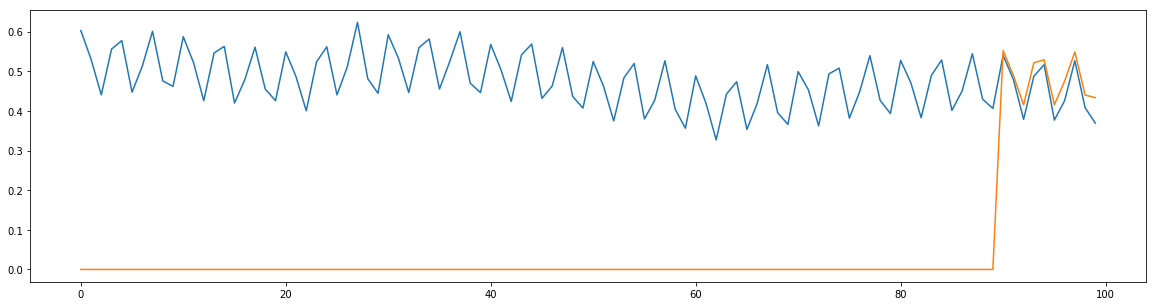

In [764]:
i = random.randint(0, X_train.shape[0])
example = X_train[i]
pred = model.predict(example.reshape(1,1,-1))
combined = np.concatenate([example,y_train[i]], axis=1).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example),pred], axis=1).squeeze()

plt.plot(combined[-100:])
plt.plot(combined_zeros[-100:])

In [768]:
# torch_model.eval()
# i = random.randint(0, X_train.shape[0])
# example = X_train[i]
# example = torch.from_numpy(example.reshape(1, 250, 1)).type('torch.FloatTensor')
# pred = torch_model(example).detach().numpy()
# combined = np.concatenate([example[0].numpy(), y_train[i].T], axis=0).squeeze()
# combined_zeros = np.concatenate([np.zeros_like(example),pred], axis=1).squeeze()

# plt.plot(combined[-50:])
# plt.plot(combined_zeros[-50:])